In [1]:
%matplotlib inline
%precision 3

import os
import re
import datetime

import numpy as np
np.set_printoptions(precision=3)
np.random.seed(123)
from numpy.random import randn
from numpy import nan as NA

import pandas as pd
pd.options.display.max_rows = 6

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

In [2]:
!powershell -command "& {gc NCDB_1999_to_2014.csv -head 6}"

C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
1999,01,1,20,2,02,34,UU,1,5,3,03,01,06,1990,01,M,41,11,1,UU,1
1999,01,1,20,2,02,34,UU,1,5,3,03,02,01,1987,01,M,19,11,1,UU,1
1999,01,1,20,2,02,34,UU,1,5,3,03,02,01,1987,02,F,20,13,2,02,2
1999,01,1,08,2,01,01,UU,5,3,6,18,01,01,1986,01,M,46,11,1,UU,1
1999,01,1,08,2,01,01,UU,5,3,6,18,99,NN,NNNN,01,M,05,99,2,UU,3


In [3]:
accident = pd.read_csv('NCDB_1999_to_2014.csv', engine = 'python')

In [4]:
#Replace all column head to lower case.
accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860402,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U
5860404,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,02,M,10,98,1,01,U


In [5]:
#Check the non-numeric values in date-time columns
accident[accident['c_mnth'].str.contains('[^0-9]')|
         accident['c_wday'].str.contains('[^0-9]')|
         accident['c_hour'].str.contains('[^0-9]')]

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
128,1999,01,1,UU,2,02,33,02,1,1,...,01,06,1990,01,M,57,11,1,02,1
129,1999,01,1,UU,2,02,33,02,1,1,...,02,01,1991,01,M,18,11,2,02,1
175,1999,01,1,UU,2,01,03,UU,1,4,...,01,01,1989,01,M,30,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860402,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U
5860404,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,02,M,10,98,1,01,U


In [6]:
#Remove all special values (unknown to us) in date-time columns, prepare for using date series as index.
#Make a copy "df" for further analysis, avoid mess up the original data "accident".

df = accident[:]
df[['c_mnth','c_wday','c_hour']]=df[['c_mnth','c_wday','c_hour']].replace('[^0-9]+',np.nan,regex=True)

df.dropna(axis=0,subset=['c_mnth','c_wday','c_hour'],inplace=True)
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860378,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1
5860379,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,02,M,26,13,1,02,2
5860380,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,03,F,15,21,2,02,2


In [7]:
#Generate the date-time column "date", which could be assigned as index later.
#Notes: Using 'PeriodIndex' to generate monthly index is very slow.

df['date'] = pd.DatetimeIndex(df['c_year'].map(str) + '-' + df['c_mnth'])
#df['date'] = pd.PeriodIndex(df['c_year'].map(str) + '-' + df['c_mnth'], freq='M')

df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,date
0,1999,01,1,20,2,02,34,UU,1,5,...,06,1990,01,M,41,11,1,UU,1,1999-01-01
1,1999,01,1,20,2,02,34,UU,1,5,...,01,1987,01,M,19,11,1,UU,1,1999-01-01
2,1999,01,1,20,2,02,34,UU,1,5,...,01,1987,02,F,20,13,2,02,2,1999-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860378,2014,12,7,19,2,01,03,01,1,3,...,01,2001,01,F,35,11,2,02,1,2014-12-01
5860379,2014,12,7,19,2,01,03,01,1,3,...,01,2001,02,M,26,13,1,02,2,2014-12-01
5860380,2014,12,7,19,2,01,03,01,1,3,...,01,2001,03,F,15,21,2,02,2,2014-12-01


---
### 1 Road Alignment
### 1.1) Road Alignment & Time relation

In [8]:
#Slice the columns I would analyse from original dataset.
dfa = df.loc[:,['date','c_year','c_mnth','c_wday','c_hour',
                'c_sev','c_vehs','c_conf','c_wthr','c_raln',
                'v_type','v_year']]

#Check how many unknown in road alignment.
dfa['c_raln'].value_counts().sort_index()

1    4122257
2     577823
3     356454
      ...   
6      27283
Q      27960
U     430099
Name: c_raln, Length: 8, dtype: int64

In [9]:
#Make a slice only focusing on c_raln: road alignment.
df1 = dfa.loc[:,['date','c_raln']]

#Aggregate the events by month into a summarized dataframe.
df2 = df1.groupby(['date','c_raln']).size().unstack()
df2

c_raln,1,2,3,4,5,6,Q,U
date,,,,,,,,
1999-01-01,21795,4097,2319,1642,152,134,11,3012
1999-02-01,17319,3017,1874,1249,111,97,7,2588
1999-03-01,19831,3233,1920,1255,140,81,12,2685
...,...,...,...,...,...,...,...,...
2014-10-01,20778,2366,1319,780,214,206,65,1569
2014-11-01,19351,2400,1574,1053,385,276,40,1546
2014-12-01,18561,2120,1700,992,330,251,25,1425


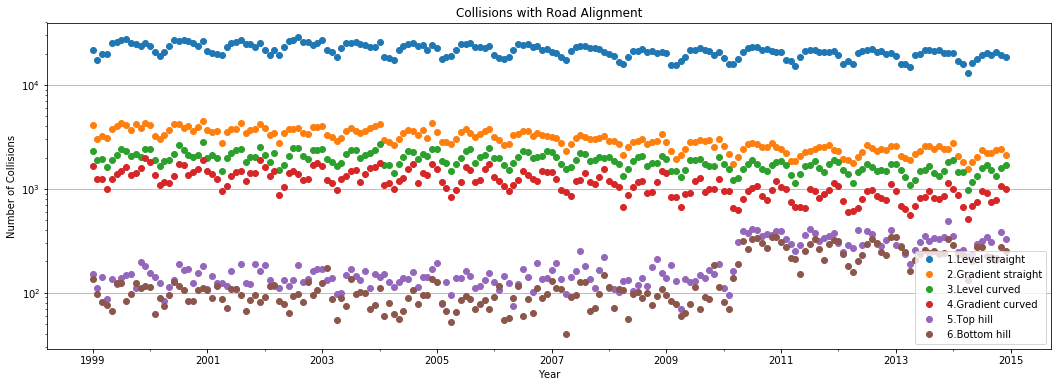

In [10]:
#Plot the dataframe into graph to visualize the result.
c_raln=['1.Level straight','2.Gradient straight',
        '3.Level curved','4.Gradient curved',
        '5.Top hill','6.Bottom hill',
        'Q.Other','U.Unknown']

df2.iloc[:,:-2].plot(logy=True, style = 'o', figsize = (18,6),
                     title = 'Collisions with Road Alignment')
plt.legend(c_raln)
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');


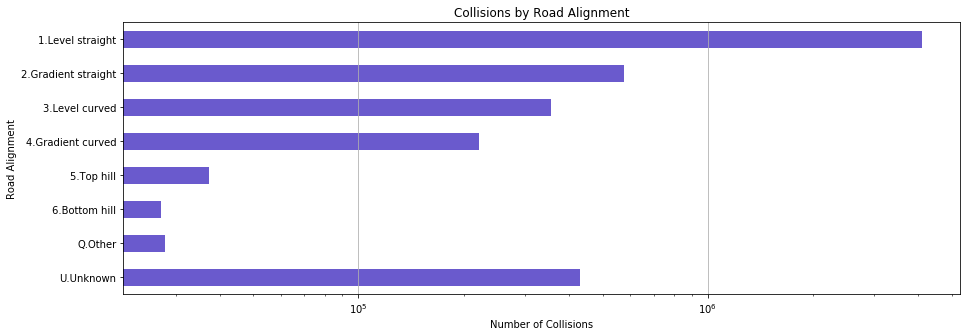

In [11]:
df3=df1.groupby('c_raln').size().sort_index(ascending=False)

df3.plot.barh(logx=True,color='slateblue',figsize=(15,5),
              title='Collisions by Road Alignment')
plt.xlabel('Number of Collisions')
plt.yticks(np.arange(0,8),c_raln[::-1])
plt.ylabel('Road Alignment')
plt.grid(axis='x');


#### Conclusion:
Most collisions happened on level and straight road, reason could be the vehicle of high speed, and driver not paying enough attention given the good road condition.  Also noted clear seasonal pattern, see the auto-correlation analysis for seasonal patterns.

### 1.2) Road Alignment & Collision Severity


In [12]:
#Use a new dataframe to analyze the relationship between Severity and Road Alignment.
#For c_sev, 1 is fatal, and 2 is non-fatal.

df1 = dfa.loc[:,['c_raln','c_sev']]
df4 = df1.groupby(['c_raln','c_sev']).size().unstack()

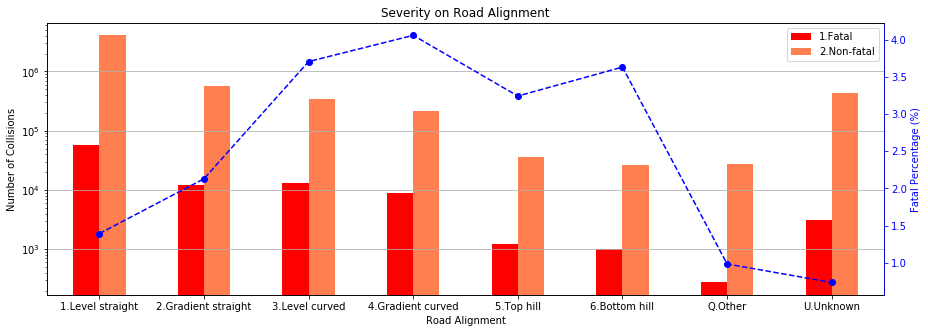

In [13]:
#Plot the relationship between Severity and Road Alignment.

#Create a twin y-axis plot area, and define axis parameters.
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

#Plot the new dataframe in logarithm, since the gap between numbers are huge.
df4.plot(kind='bar',rot=0,logy=True,color=['red','coral'],figsize=(15,5),title='Severity on Road Alignment', ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Road Alignment')
ax1.grid(axis='y')
ax1.legend(['1.Fatal','2.Non-fatal'])

#Calculate the percentage of fatal injury in all accidents by different road alignment, and plot to right axis.
se1 = df4[1]/(df4[1]+df4[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

plt.xticks(np.arange(0,8),c_raln);


#### Conclusion:
Fatal injury represent a very small portion of all accident (less than 4% in any given cases).  It's also obvious that the level-straight road has less fatal injury, though the total number is much more than other cases; instead, the uneven condition (straight and curved) may produce severe accident.  This could be caused by limited sight.

### 1.3) Road Alignment & Number of Vehicles Involved in Collision


In [14]:
df1 = dfa.loc[:,['c_raln','c_vehs']]
df1.c_vehs.replace('UU',np.nan, inplace=True)
df1.dropna(inplace=True)
df1.c_vehs=df1.c_vehs.astype(int)
df1.c_vehs.value_counts().sort_index()

#Calculate accident portion of each event, considering 58 records that have 57 vehicle involved,
# that should be just one accident, every relevant record should be only about 1/57.
df1['acc']= 1/df1.c_vehs

#Categorize number of involved vehicles into bins.
bins = [0,5,10,20,40,60]
df1['cats'] = pd.cut(df1.c_vehs,bins)

#Summarize the collisions on road alignment and number of involved vehicles.
df5 = df1.groupby(['cats','c_raln'])['acc'].sum().unstack()
df5.dropna(how='all', inplace=True)
df5.fillna(0, inplace=True)
df5

c_raln,1,2,3,4,5,6,Q,U
cats,,,,,,,,
"(0, 5]",2.287831e+06,324641.150000,254893.316667,158273.766667,23375.216667,17733.616667,17535.366667,233456.566667
"(5, 10]",2.562835e+03,690.660317,166.184921,143.411111,55.061508,20.053571,24.761905,181.832540
"(10, 20]",1.868001e+02,35.677092,11.163280,30.610907,6.319430,1.200000,3.579983,15.766346
"(20, 40]",4.285347e+01,7.202378,1.111111,3.434295,1.409091,0.000000,0.000000,0.000000
"(40, 60]",4.201603e+00,3.544055,1.568627,0.000000,0.000000,2.819865,0.000000,0.000000


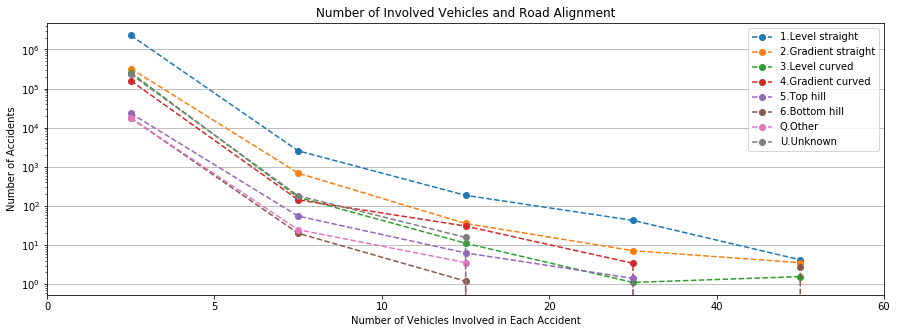

In [15]:
#Plot the result.

df5.plot(logy=True,figsize=(15,5),style='o--',title='Number of Involved Vehicles and Road Alignment')
plt.xticks(np.arange(-0.5,5.5),bins)
plt.xlabel('Number of Vehicles Involved in Each Accident')
plt.ylabel('Number of Accidents')
plt.legend(c_raln)
plt.grid(axis='y');

#### Conclusion:
Majority accident are involving less than 5 cars.  As the plots are very similar for different road alignments, no specific relationship observed between the two variables.

### 1.4) Road Alignment & Collision Configuration

In [16]:
#Prepare the dataset for analyse, replace non-numeric value into number to use in scatter plot.
df1 = dfa.loc[:,['c_raln','c_conf']]
df1.c_raln = df1.c_raln.replace({'Q':7,'U':8}).astype(int)
df1.c_conf = df1.c_conf.replace({'QQ':42,'UU':43,'XX':43}).astype(int)

In [17]:
#Too many collision configuration involved, iterate a list of dateframes to separate different collision config.
df6 = []
df6.append( df1[df1.c_conf < 10] )
df6.append( df1[(df1.c_conf > 20)&(df1.c_conf < 30)] )
df6.append( df1[(df1.c_conf > 30)&(df1.c_conf < 40)] )
df6.append( df1[df1.c_conf > 40] )


In [18]:
#Reformat the dataframe, to summarize the collision numbers in different situation, and store in another list of
# dataframe 'df7'

se6 = []; df7 = []
for i in range(0,4):
    se6.append( df6[i].groupby(['c_raln','c_conf']).size() )
    se6[i].name = 'collision'
    df7.append( pd.DataFrame(se6[i]).reset_index() )

df7[3]

,c_raln,c_conf,collision
0,1,41,60847
1,1,42,189970
2,1,43,117354
...,...,...,...
21,8,41,3618
22,8,42,8018
23,8,43,24382


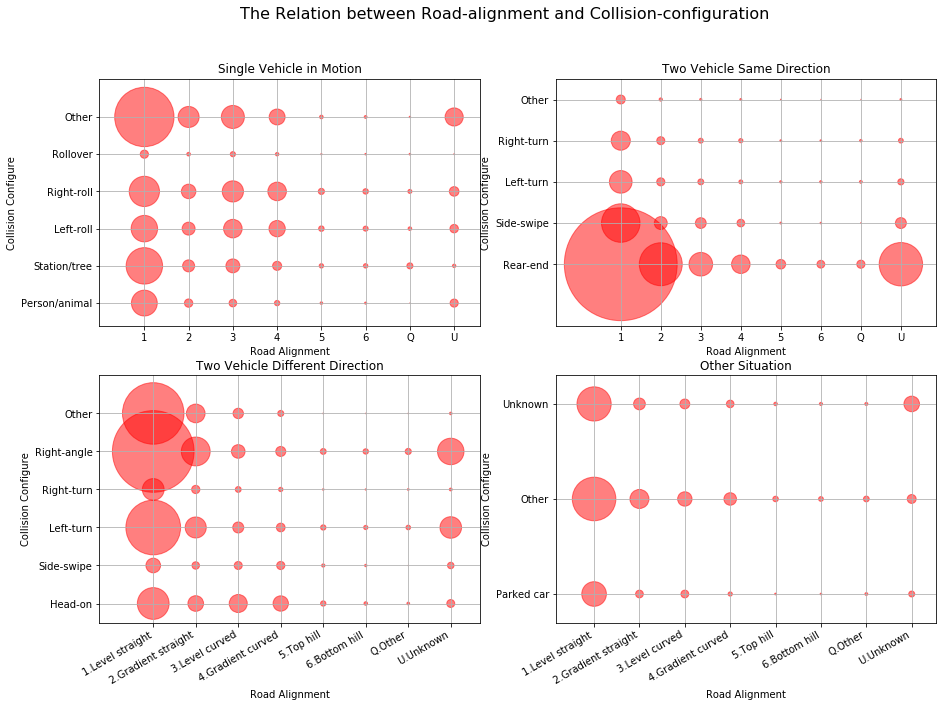

In [19]:
#Draw four subplots to show the relation between the road alignment and different collision situations.

fig = plt.figure(figsize=(15, 10))
fig.suptitle("The Relation between Road-alignment and Collision-configuration", fontsize = 16)

#---------------------- Only one car involved in collision. ---------------------- 
ax1 = fig.add_subplot(2,2,1)
ax1.set_xticks(range(1,9))
ax1.set_xticklabels([1,2,3,4,5,6,'Q','U'])
ax1.set_xlabel("Road Alignment")

ax1.set_yticks(range(1,7))
ax1.set_yticklabels(['Person/animal','Station/tree','Left-roll','Right-roll','Rollover','Other'])
ax1.set_ylabel("Collision Configure")

ax1.set_title("Single Vehicle in Motion")
ax1.scatter(df7[0].c_raln,df7[0].c_conf,
            df7[0].collision*.01,
            alpha=0.5,color='r')
plt.grid(which='major')

#---------------------- Two car same direction. ---------------------- 
ax2 = fig.add_subplot(2,2,2)
ax2.set_xticks(range(1,9))
ax2.set_xticklabels([1,2,3,4,5,6,'Q','U'])
ax2.set_xlabel("Road Alignment")


ax2.set_ylim([19.5,25.5])
ax2.set_yticks(range(21,26))
ax2.set_yticklabels(['Rear-end','Side-swipe','Left-turn','Right-turn','Other'])
ax2.set_ylabel("Collision Configure")

ax2.set_title("Two Vehicle Same Direction")
ax2.scatter(df7[1].c_raln,df7[1].c_conf,
            df7[1].collision*.01,
            alpha=0.5,color='r')
plt.grid(which='major')

#---------------------- Two car different direction. ---------------------- 
ax3 = fig.add_subplot(2,2,3)
ax3.set_xticks(range(1,9))
ax3.set_xticklabels(c_raln,rotation=30,ha='right')
ax3.set_xlabel("Road Alignment")

ax3.set_ylim([30.5,37])
ax3.set_yticks(range(31,37))
ax3.set_yticklabels(['Head-on','Side-swipe','Left-turn','Right-turn','Right-angle','Other'])
ax3.set_ylabel("Collision Configure")

ax3.set_title("Two Vehicle Different Direction")
ax3.scatter(df7[2].c_raln,df7[2].c_conf,
            df7[2].collision*.01,
            alpha=0.5,color='r')
plt.grid(which='major')

#---------------------- Other situation. ---------------------- 
ax4 = fig.add_subplot(2,2,4)
ax4.set_xticks(range(1,9))
ax4.set_xticklabels(c_raln,rotation=30,ha='right')
ax4.set_xlabel("Road Alignment")

ax4.set_ylim([40.7,43.3])
ax4.set_yticks(range(41,44))
ax4.set_yticklabels(['Parked car','Other','Unknown'])
ax4.set_ylabel("Collision Configure")

ax4.set_title("Other Situation")
ax4.scatter(df7[3].c_raln,df7[3].c_conf,
            df7[3].collision*.01,
            alpha=0.5,color='r')
plt.grid(which='major');

#### Conclusion:
The size of each dot indicate the collision numbers in each setting, same scale factor used for all subplots, which makes the number in each plot comparable to its neighbour.  In all cases, clear trend shows that the collision chance increases when road-alignment getting better, due to higher speed and less caution.  Except the unknown or "other" conditions, we can see in each cases:
1. most collision for one car accident is hitting a static object, followed closely by right and left roll on to shoulder.
2. for two car in same direction, most accidents are rear-end collision, which clearly increase along road-alignment.
3. for two car in different direction, right-angle collision is huge, guess is in intersection.  Left turn also post a lot risk, but right-turn is very low, even lower than head-on collision.  This may be a result of the inherent complexity of left turn.

### Conclusion from Road Alignment analysis:
From all test performed above, we have following observations:
1. Most collisions happened in level and aligned road.  Drivers should pay more attention when drive on good road condition, and follow speed limit.
2. However, bad road alignment may post higher risk of fatal accident.  Drivers need to anticipate possible outcome when the view is not so wide, and always be cautious to avoid serious injury as possible.
3. Rear-end collision is the most popular collision type.  Keep enough space to the car in front of you, especially on well aligned road.
4. Right-angle collision and left-turn collision are also popular, wait one more second before turning your wheel, or rushing into the intersection.

---
### 2 Vehicle Type
### 2.1) Vehicle Type & Time Relation

In [20]:
df1 = dfa.loc[:,['c_mnth','v_type']]

#Aggregate the events by month into a summarized dataframe.
df2 = df1.groupby(['c_mnth','v_type']).size().unstack()
df2.index = df2.index.astype(int)
df2.fillna(0, inplace=True)

v_type = ['1.Light Duty', '5.Cargo <4.5t', '6.Truck <4.5t',
          '7.Truck >4.5t', '8.Road tractor', '9.School bus',
          '10.Small school bus', '11.Urban bus', '14.Motorcycle',
          '16.Off-road', '17.Bicycle', '18.Motorhome', '19.Farm equip.',
          '20.Constru. equip.', '21.Fire engine', '22.Snowmobile',
          '23.Street car', 'N.Not vehicle', 'Q.Others', 'U.Unknown']
months = ['Jan','Feb','Mar','Apr','May','Jun',
          'Jul','Aug','Sep','Oct','Nov','Dec']

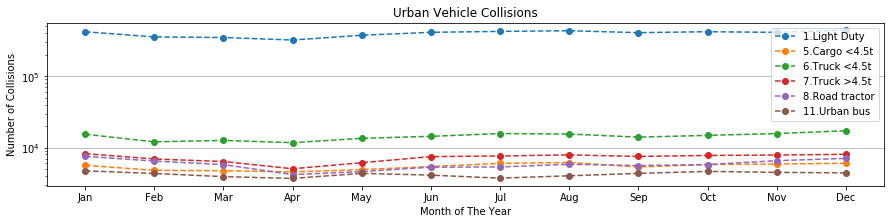

In [21]:
#df2.plot(logy=True, figsize = (18,10), style = 'o--', title = 'Collisions with Road Alignment');
df2.iloc[:,[0,1,2,3,4,7]].plot(logy=True, figsize = (15,3), style = 'o--', title = 'Urban Vehicle Collisions')
plt.legend(v_type[0:5]+[v_type[7]])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

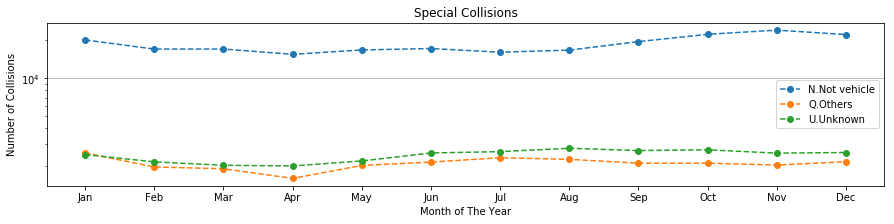

In [22]:
df2.iloc[:,17:20].plot(logy=True, figsize = (15,3), style = 'o--', title = 'Special Collisions')
plt.legend(v_type[17:20])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

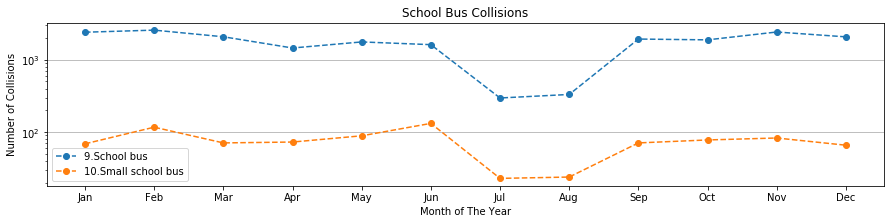

In [23]:
df2.iloc[:,5:7].plot(logy=True, figsize = (15,3), style = 'o--', title = 'School Bus Collisions')
plt.legend(v_type[5:7])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

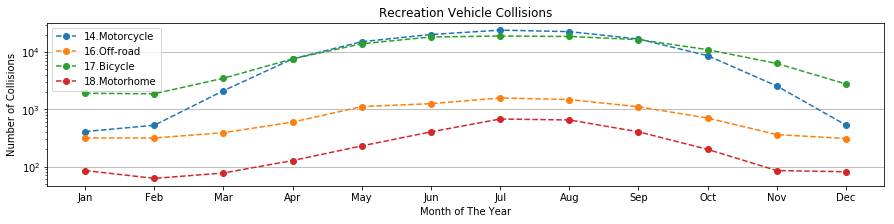

In [24]:
df2.iloc[:,8:12].plot(logy=True, figsize = (15,3), style = 'o--', title = 'Recreation Vehicle Collisions')
plt.legend(v_type[8:12])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

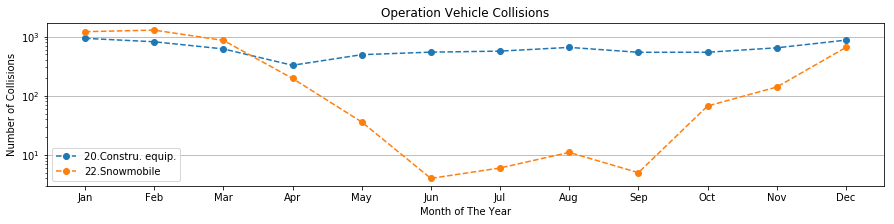

In [25]:
df2.iloc[:,[13,15]].plot(logy=True, figsize = (15,3), style = 'o--', title = 'Operation Vehicle Collisions')
plt.legend([v_type[13],v_type[15]])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

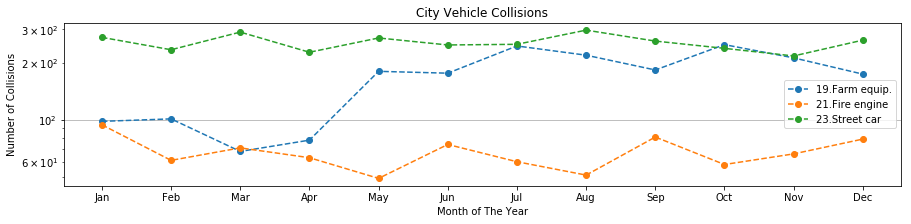

In [26]:
df2.iloc[:,[12,14,16]].plot(logy=True, figsize = (15,3), style = 'o--', title = 'City Vehicle Collisions')
plt.legend([v_type[12],v_type[14],v_type[16]])
plt.xticks(range(1,13),months)
plt.xlabel('Month of The Year')
plt.ylabel('Number of Collisions')
plt.grid(axis='y');

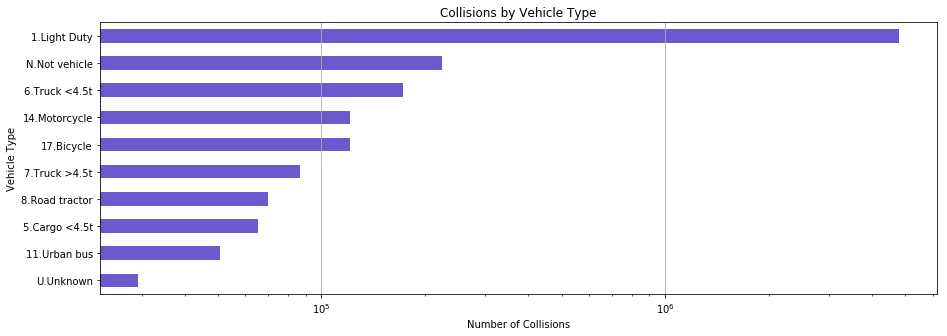

In [27]:
#Plot the total collisions by different vehicle types (top 10):

df3 = pd.DataFrame(df1.groupby('v_type').size().sort_index())
df3['types'] = v_type
df3 = df3.rename(columns={0:'collisions'}).set_index('types').sort_values(by='collisions')

df3[-10:].plot.barh(logx=True,color='slateblue',figsize=(15,5),title='Collisions by Vehicle Type',legend=None)
plt.xlabel('Number of Collisions')
plt.ylabel('Vehicle Type')
plt.grid(axis='x');

#### Conclusion:
By looking at the plots above, clear pattern shown in different vehicle types:
1. Vast majority collisions are caused by light duty vehicles, followed by light truck, motorcycle and bicycle.  This is due to the dominant population of the personal vehicles, and the unprofessional nature of the drivers.
2. The collisions distribution for urban vehicles (light duty, trucks, road tractor, and bus) is flat across all seasons, without showing obvious pattern, indicating urban traffic being busy for all time.
3. School bus involved collisions happened much less in July and August, due to summer vacation.
4. More accident related to bicycle, motorcycle, off-road vehicle and motorhome happened from April to October, as they are used for outdoor activities during summer time; in opposite, snow-mobile collisions are more from October to April.

### 2.2) Vehicle Type & Severity

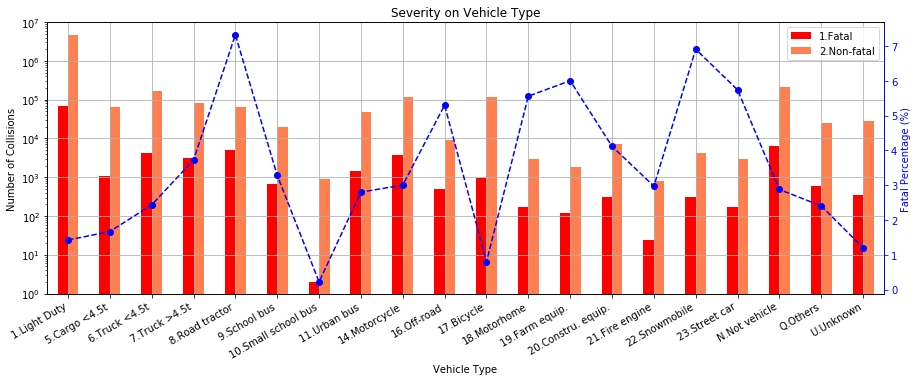

In [28]:
#Use a new dataframe to analyze the relationship between Severity and Road Alignment.
#For c_sev, 1 is fatal, and 2 is non-fatal.

df1 = dfa.loc[:,['v_type','c_sev']]
df4 = df1.groupby(['v_type','c_sev']).size().unstack().fillna(0)

#Plot the relationship between Severity and Vehicle Type.

#Create a twin y-axis plot area, and define axis parameters.
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

#Plot the new dataframe in logarithm, since the gap between numbers are huge.
df4.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity on Vehicle Type', ax=ax1)
ax1.set_xticklabels(v_type,ha='right')
ax1.set_xlabel('Vehicle Type')
ax1.set_ylabel('Number of Collisions')
ax1.grid(axis='both')
ax1.legend(['1.Fatal','2.Non-fatal'])

#Calculate the percentage of fatal injury in all accidents by different road alignment,
# and plot to right axis.
se1 = df4[1]/(df4[1]+df4[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

plt.xticks(np.arange(0,20),v_type);


#### Conclusion:
From the figure above we see most fatal collisions are caused by light-duty vehicles, followed by motorcycle, road tractor, and trucks.  However, the highest percentage of fatal accidents is caused by road tractor and Snowmobile (about 7%), and followed by street car, farm equipment and motorhome (around 6%).
Also noticed that small school bus produces least fatal collisions, and bicycle number is also non-surprisingly low.


### Conclusion from Vehicle Type analysis:
Clear seasonal patterns observed for certain types:
- School bus involved in collisions out of summer vacation (July and August);
- Vehicles for out-door activities (i.e., bicycle, motorcycle, off-road vehicle and motorhome) involved in collisions mostly during summer time (April to October);
- In opposite, snow-mobile collisions are more from October to April.

While light duty vehicles, light trucks, motorcycles and bicycles involved in most of the collisions, most fatal collision ratio observed from following types:
- Road tractor and Snowmobile is around 7%;
- Street car, farm equipment and motorhome is about 6%.

If you see those vehicle when you drive, try stay away from them.

---
### 3. Vehicle Model Year
### 3.1) Vehicle Model Year & Time Relation

In [29]:
#Prepare the dataset and clean it.
df1 = dfa.loc[:,['c_year','v_year']]

df1.v_year.replace({'NNNN':NA,'UUUU':NA,'XXXX':NA},inplace=True)
df1.dropna(inplace=True)
df1 = df1.astype(int)

#Aggregate the collisions by year into a summarized dataframe (model year as index).
df2 = df1.groupby(['v_year','c_year']).size().unstack()
df2.fillna(0, inplace=True)
df2 = df2.astype(int)
df2

c_year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
v_year,,,,,,,,,,,,,,,,
1901,10,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0
1903,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1904,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1497,14284,19093
2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1362,12926
2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1223


In [30]:
#Number of collisions grouped by vehicle model year range (12 ranges as columns)
bins = list(range(1900,2021,10))
df2['cats'] = pd.cut(df2.index,bins,labels=bins[:-1])
df3 = df2.groupby('cats').sum().T
df3

cats,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
c_year,,,,,,,,,,,,
1999,31,16,13,24,33,108,825,8669,140947,216958,0,0
2000,0,29,20,79,27,91,635,7013,125229,241490,2221,0
2001,2,16,28,49,29,66,535,5574,102097,233222,24967,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0,3,8,7,5,20,129,509,3969,57286,194283,31792
2013,0,5,11,5,11,24,123,385,3088,44588,184030,51811
2014,0,17,6,3,6,24,88,346,2487,34301,162115,66719


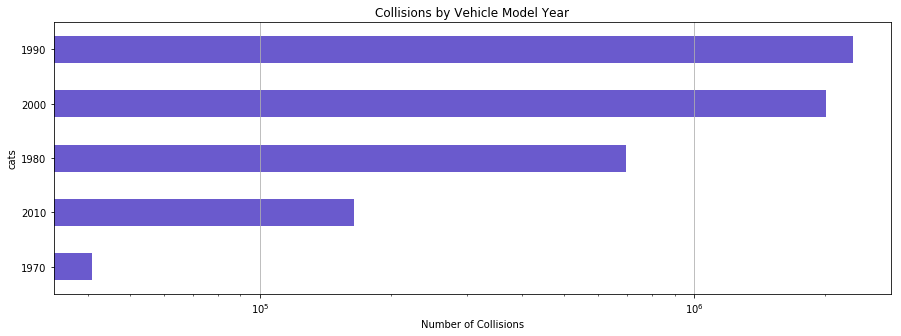

In [31]:
#Plot result of most involved model years:
se4=df3.sum().sort_values()
se4[-5:].plot.barh(logx=True,color='slateblue',figsize=(15,5),title='Collisions by Vehicle Model Year')
plt.xlabel('Number of Collisions')
plt.grid(axis='x');

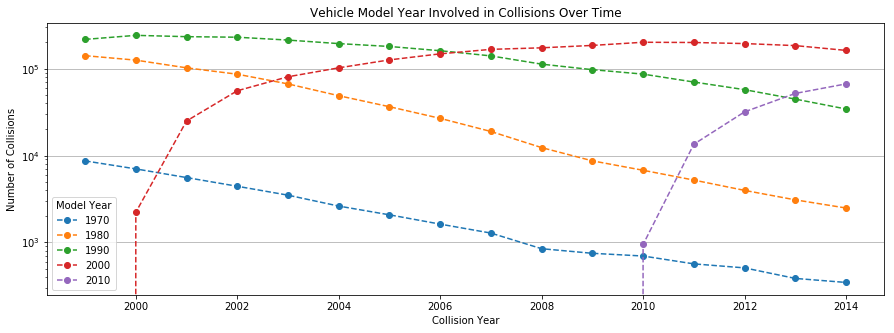

In [32]:
#Plot the trending of model year involved in collision.
df3.iloc[:,7:].plot(logy=True,style='o--',figsize=(15,5),
                    title='Vehicle Model Year Involved in Collisions Over Time')
plt.xlabel('Collision Year')
plt.ylabel('Number of Collisions')
plt.legend(title='Model Year')
plt.grid(axis='y');

### Conclusion from Vehicle Model Year analysis:
As the data covers collisions from 1999 to 2014, most cars involved in collisions are made in recent thirty years.
Clear trend observed that the model getting involved in collision peaks in its 10 years' age, which could be a result of the market share growth and the reliability drops for old vehicles.

## The End